In [2]:
import os, sys
import matplotlib.pyplot as plt

In [3]:
from pybird.config import set_jax_enabled, get_jax_enabled
set_jax_enabled(True)
if get_jax_enabled(): from jax.numpy import array
else: from numpy import array
from pybird.correlator import Correlator
from pybird.projection import Hubble, DA
from pybird.io_pb import get_dict_from_hdf5

jax: on


In [4]:
import h5py
datafile = os.path.join('..', 'data', 'eftboss', 'boss_dr12_2pt.h5')
with h5py.File(datafile, 'r') as hf: d = get_dict_from_hdf5(hf)
survey_mask = d['cmass_ngc']['bPk']['survey_mask']

In [5]:
z, Om_fid = 0.57, 0.300
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
eft_params = {'b1': 1.95, 'b2': 0.41, 'b3': -0.36, 'b4': 0.41, 'cct': 0.18, 'cr1': -0.84, 'cr2': -0.81, 'ce0': 1.50, 'ce1': 0.0, 'ce2': -1.63}

In [6]:
N = Correlator()
N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.3, 'z': z, 'km': 0.7, 'kr': 0.35, 'nd': 3e-4, 'eft_basis': 'eftoflss', 'with_stoch': True,
'with_ap': True, 'H_fid': Hubble(Om_fid, z), 'D_fid': DA(Om_fid, z),
'with_emu': True,
'with_survey_mask': True, 'survey_mask_arr_p': survey_mask['arr_p'], 'survey_mask_mat_kp': survey_mask['mat_kp']
}) 

In [7]:
N.compute(cosmo, cosmo_module='Symbolic') 
bPk = N.get(eft_params)

In [8]:
from jax import jit
@jit
def test(cosmo, eft_params):
    N.compute(cosmo, cosmo_module='Symbolic')
    bPk = N.get(eft_params)
    return bPk

bPk = test(cosmo, eft_params) # jitting

In [ ]:
from timeit import timeit
print("Benchmarking JAXBird...")
num_runs = 20000
emu_time = timeit(lambda: test(cosmo, eft_params), number=num_runs)
avg_time = emu_time / num_runs
print(f"JAXBird: {avg_time:.5f} seconds per evaluation")

Benchmarking JAXBird...
JAXBird: 0.00289 seconds per evaluation


In [ ]:
# AP, win: 0.00289 seconds per evaluation
# AP, no win: 0.00158 seconds per evaluation
# no AP, no win: 0.00055 seconds per evaluation

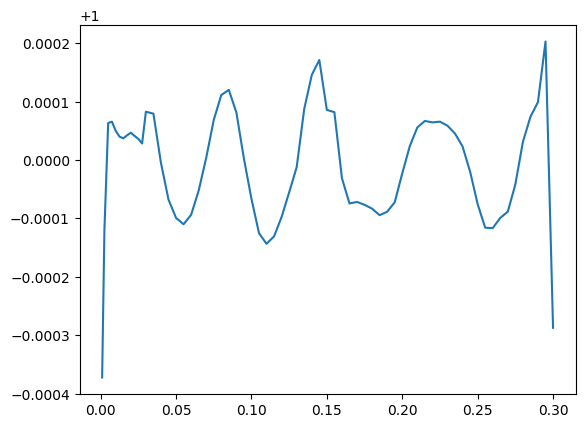

In [418]:
for i in range(1): plt.plot(N.co.k, bPk[i]/bPk_[i])

### Test $\xi(s)$

In [18]:
from pybird.config import set_jax_enabled, get_jax_enabled
set_jax_enabled(True)
if get_jax_enabled(): from jax.numpy import array
else: from numpy import array
from pybird.correlator import Correlator

jax: on


In [42]:
import numpy as np
sd = np.arange(10, 200, 2)

N = Correlator()
N.set({'output': 'bCf', 'multipole': 3, 'z': z, 'xdata': array(sd), 'km': 0.7, 'kr': 0.35, 'nd': 3e-4, 'eft_basis': 'eftoflss', 
    'fftaccboost' : 1, # reduced accuracy for speedup in testing
    'with_resum': False,
    # 'with_ap': True, 'H_fid': Hubble(Om_fid, z), 'D_fid': DA(Om_fid, z),
}) 

In [43]:
N.compute(cosmo, cosmo_module='Symbolic') 
bCf = N.get(eft_params)

In [44]:
from jax import jit
@jit
def test(cosmo, eft_params):
    N.compute(cosmo, cosmo_module='Symbolic')
    bCf = N.get(eft_params)
    return bCf

bCf = test(cosmo, eft_params) # jitting

In [45]:
from timeit import timeit
print("Benchmarking JAXBird...")
num_runs = 1000
emu_time = timeit(lambda: test(cosmo, eft_params), number=num_runs)
avg_time = emu_time / num_runs
print(f"JAXBird: {avg_time:.5f} seconds per evaluation")

Benchmarking JAXBird...
JAXBird: 0.06527 seconds per evaluation


In [ ]:
# resum: 0.06527 seconds per evaluation
# no resum: 0.06708 seconds per evaluation

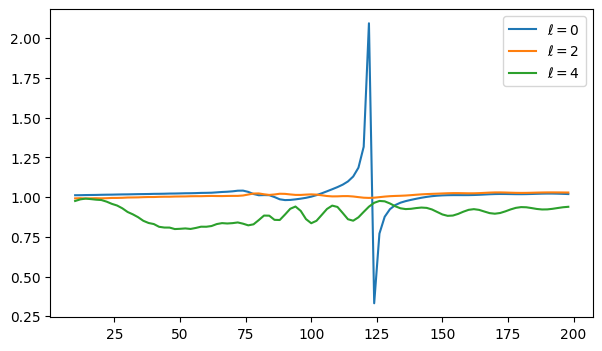

In [35]:
plt.figure(figsize=(7,4))
for i in range(3): plt.plot(sd, bCf[i]/bCf_[i], label=r'$\ell=%s$' % (2*i))
plt.legend()
plt.show()

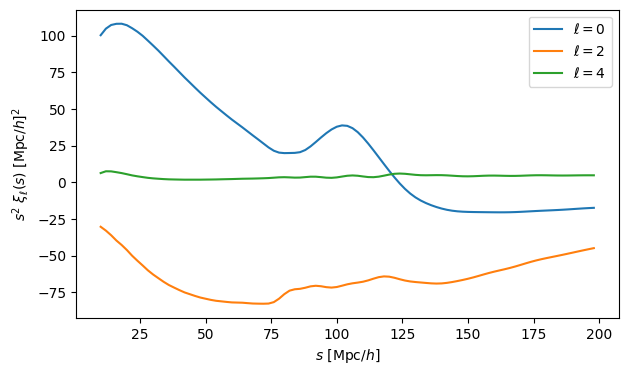

In [36]:
plt.figure(figsize=(7,4))
for i in range(3): plt.errorbar(sd, sd**2 * bCf[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$s \ [{\rm Mpc}/h]$')
plt.ylabel(r'$s^2 \ \xi_\ell(s) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()